In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

### Data preparation

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'
df = pd.read_csv(data)

In [3]:
df.columns = df.columns.str.lower()

status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

df = df[df.status != 'unk'].reset_index(drop=True)

In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=11)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

del df_train['status']
del df_test['status']

In [5]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.fillna(0).to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

test_dicts = df_test.fillna(0).to_dict(orient='records')
X_test = dv.transform(test_dicts)

### Random forest

In [6]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

### XGBoost

Note:

We removed feature names

It was 

```python
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
```

Now it's

```python
dtrain = xgb.DMatrix(X_train, label=y_train)
```

In [7]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [8]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

### BentoML

In [9]:
import bentoml

In [10]:
bentoml.xgboost.save_model(
    'credit_risk_model',
    model,
    custom_objects={
        'dictVectorizer': dv
    })

Model(tag="credit_risk_model:pdsrzg2vhoablygu", path="C:\Users\91635\bentoml\models\credit_risk_model\pdsrzg2vhoablygu\")

Test

In [11]:
import json

In [12]:
request = df_test.iloc[0].to_dict()
print(json.dumps(request, indent=2))

{
  "seniority": 3,
  "home": "owner",
  "time": 36,
  "age": 26,
  "marital": "single",
  "records": "no",
  "job": "freelance",
  "expenses": 35,
  "income": 0.0,
  "assets": 60000.0,
  "debt": 3000.0,
  "amount": 800,
  "price": 1000
}


### Question 1
* Install BentoML
* What's the version of BentoML you installed?
* Use --version to find out

### Answer 1

In [13]:
bentoml.__version__

'1.0.7'

### Question 2
* Run the notebook which contains the xgboost model from module 6 i.e previous module and save the xgboost model with BentoML. To make it easier for you we have prepared this notebook.

* How big approximately is the saved BentoML model? Size can slightly vary depending on your local development environment. Choose the size closest to your model.

    * 924kb
    * 724kb
    * 114kb
    * 8kb

### Answer 2
The closest value to the size of the model in my local is 114kb.
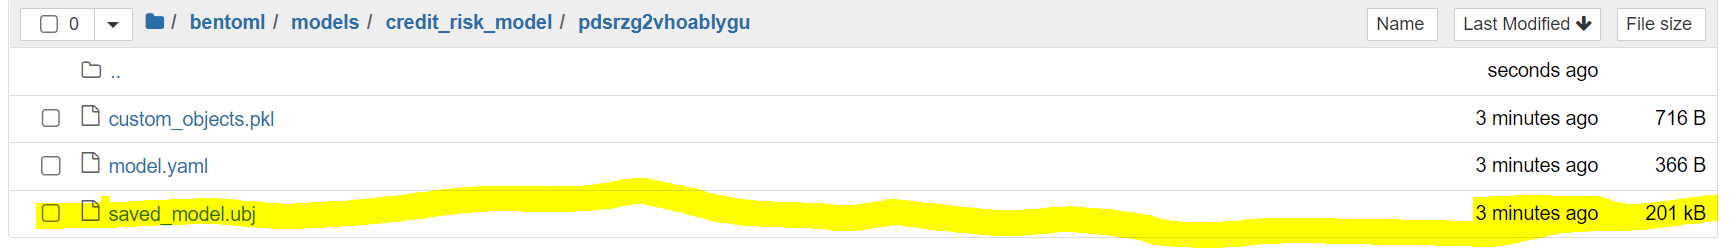

### Question 3
* Say you have the following data that you're sending to your service:

{
  "name": "Tim",
  "age": 37,
  "country": "US",
  "rating": 3.14
}
* What would the pydantic class look like? You can name the class UserProfile.

### Answer 3
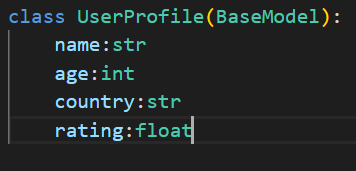